# PRÁCTICA 2 - Regresión

### SETUP

In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numbers
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from typing import List, Union, Dict, Any, Tuple
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from matplotlib.figure import Figure
from matplotlib.axes import Axes

In [26]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(" ", "_") 
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip()
    return df

### Regresión Lineal

In [27]:
def print_tabulate(df: pd.DataFrame):
    print(tabulate(df, headers=df.columns, tablefmt="orgtbl"))

In [28]:
def transform_variable(df: pd.DataFrame, x:str)->pd.Series:
    if isinstance(df[x][0], numbers.Number):
        return df[x]
    else:
        return pd.Series([i for i in range(0, len(df[x]))])

In [29]:
def linear_regression(df: pd.DataFrame, x:str, y: str)->None:
    fixed_x = transform_variable(df, x)
    model= sm.OLS(df[y],sm.add_constant(fixed_x)).fit()
    print(model.summary())

    coef = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef']
    df.plot(x=x,y=y, kind='scatter')
    plt.plot(df[x],[ coef.values[1] * x + coef.values[0] for _, x in fixed_x.items()], color='red')

    plt.xticks(rotation=90, fontsize=8)  

    plt.title('Regresión Lineal Visitantes Recurrentes vs Cargas de Página')
    plt.xlabel("Cantidad de visitantes recurrentes")
    plt.ylabel("Cargas Promedio")

    print("R-squared:", model.rsquared)
    print("Adjusted R-squared:", model.rsquared_adj)

In [44]:
df = pd.read_csv("website.csv")
df = clean_column_names(df)
df.head(5)


,row,day,day.of.week,date,page.loads,unique.visits,first.time.visits,returning.visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278
3,4,Wednesday,4,9/17/2014,3667,2614,2327,287
4,5,Thursday,5,9/18/2014,3316,2366,2130,236


In [47]:
df['date'] = pd.to_datetime(df['date'])
fecha_minima = df['date'].min()
fecha_maxima = df['date'].max()
suma_page_loads = df['page.loads'].sum()
promedio_page_loads = df['page.loads'].mean()
suma_unique_visits = df['unique.visits'].sum()
resumen = (
    f"La fecha mínima es {fecha_minima.strftime('%Y-%m-%d')}, "
    f"y la fecha máxima es {fecha_maxima.strftime('%Y-%m-%d')}. "
    f"En total hubo {suma_unique_visits:,} visitas únicas. "
    f"La suma total de cargas de página fue de {suma_page_loads:,} y su promedio diario es {promedio_page_loads:.2f}."
)
print(resumen)

La fecha mínima es 2014-09-14, y la fecha máxima es 2020-08-19. En total hubo 6,378,882 visitas únicas. La suma total de cargas de página fue de 8,921,516 y su promedio diario es 4116.99.


In [33]:
#df['page.loads'] = df['page.loads'].str.replace(',', '').astype(float)
df = df[["returning.visits","page.loads"]].groupby(["returning.visits"])[["page.loads"]].agg({'page.loads': ['mean']})
df.reset_index(inplace=True)
df.columns = ["returning_visits","mean_load"]
df.head(5)

,returning_visits,mean_load
0,133,1658.0
1,138,1017.0
2,140,1656.0
3,145,1002.0
4,150,1742.0


|     |   returning_visits |   mean_load |
|-----+--------------------+-------------|
|   0 |                133 |     1658    |
|   1 |                138 |     1017    |
|   2 |                140 |     1656    |
|   3 |                145 |     1002    |
|   4 |                150 |     1742    |
|   5 |                152 |     2146    |
|   6 |                157 |     1682    |
|   7 |                160 |     1345    |
|   8 |                161 |     1265    |
|   9 |                162 |     2054    |
|  10 |                174 |     1681.5  |
|  11 |                175 |     1761    |
|  12 |                176 |     1408.5  |
|  13 |                177 |     2080    |
|  14 |                178 |     1405    |
|  15 |                181 |     1950    |
|  16 |                182 |     1381    |
|  17 |                183 |     1338    |
|  18 |                184 |     1532    |
|  19 |                185 |     1751    |
|  20 |                187 |     1750    |
|  21 |    

C:\Users\HP\AppData\Local\Temp\ipykernel_10396\1638823528.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  coef = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['coef']


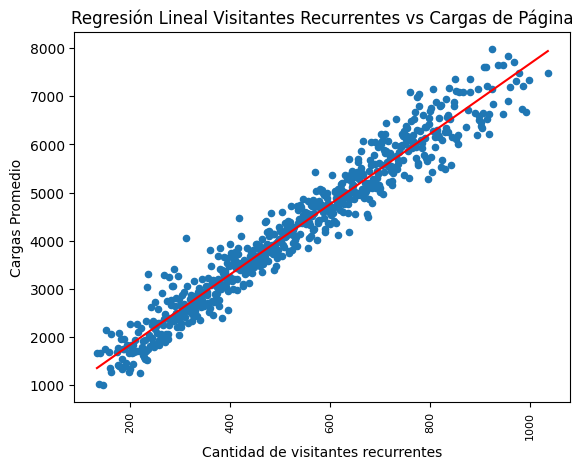

In [34]:
print_tabulate(df)
linear_regression(df, "returning_visits", "mean_load")

### Regresion Polinomial

In [35]:
def polynomial_regression(df: pd.DataFrame, x:str, y: str, degree:int) -> None:
    fixed_x = transform_variable(df, x)
    fixed_x = fixed_x.values.reshape(-1, 1)
    
    poly = PolynomialFeatures(degree=degree)
    fixed_x = poly.fit_transform(fixed_x)
    
    model = sm.OLS(df[y], fixed_x).fit()
    print(model.summary())

    coef = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]['coef']
    df.plot(x=x, y=y, kind='scatter')
    plt.plot(df[x], [sum(coef.values[i] * (x**i) for i in range(degree+1)) for x in fixed_x[:, 1]], color='red')
    plt.xticks(rotation=90, fontsize=8)  

    plt.title('Regresión Polinomial Visitantes Recurrentes vs Cargas Promedio')
    plt.xlabel("Cantidad de Visitantes Recurrentes")
    plt.ylabel("Cargas Promedio")
    plt.show()

                            OLS Regression Results                            
Dep. Variable:              mean_load   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     4100.
Date:                Sat, 27 Jul 2024   Prob (F-statistic):               0.00
Time:                        00:36:03   Log-Likelihood:                -4829.7
No. Observations:                 663   AIC:                             9667.
Df Residuals:                     659   BIC:                             9685.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        525.2990    182.895      2.872      0.0

C:\Users\HP\AppData\Local\Temp\ipykernel_10396\3919778045.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  coef = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]['coef']


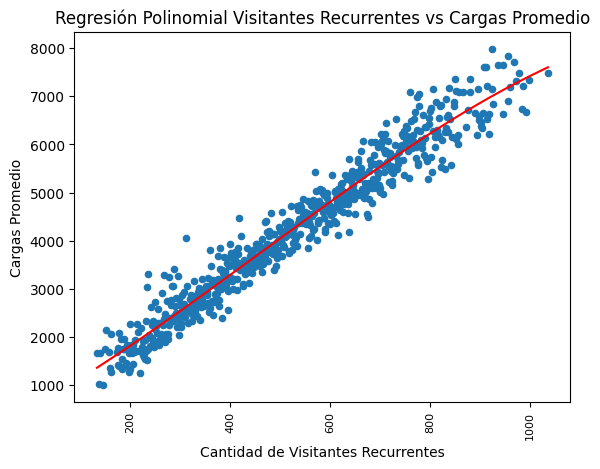

In [36]:
polynomial_regression(df, "returning_visits", "mean_load", 3)

### Regresión KNN

In [37]:
def change_variable(df: pd.DataFrame, x:str) -> np.ndarray:
    if isinstance(df[x][0], numbers.Number):
        return df[x].values
    else:
        return np.arange(len(df[x]))

In [38]:
def train_model(x,y,
                model_class:Union[type[KNeighborsRegressor], type[LinearRegression], type[Ridge], type[Lasso]],
                model_params: Dict[str, Any]) \
                ->Union[KNeighborsRegressor, LinearRegression, Ridge, Lasso]:
    print(f"Using {model_class.__name__} with {model_params}")
    model = model_class() if model_params is None or len(model_params)==0 else model_class(**model_params)
    trained_model = model.fit(x,y)
    return trained_model

In [39]:
def create_plot(subplots: int=111) -> Tuple[plt.Figure, plt.Axes]:
    fig = plt.figure()
    ax = fig.add_subplot(subplots)
    plt.xticks(rotation=90, fontsize=8)  
    plt.title('KNN Promedio de Cargas de Página')
    plt.xlabel("Cantidad de Visitantes Recurrentes")
    plt.ylabel("Cargas Promedio")
    return fig, ax

def plot_points(ax: Axes, x,y, scatter_params:Dict[str,Any]):
    return ax.scatter(x,y,**scatter_params)

def plot_line(ax: Axes,x,y,color,label='line'):
    return ax.plot(x,y,color=color, label=label)

In [40]:
def KNN_regression(df: pd.DataFrame, x:str, y:str, neighbors: List[int])->None:
    fixed_x = change_variable(df,x)
    fig, ax = create_plot()
    plot_points(ax, df[x], df[y], scatter_params={'marker':'.', 'c':'blue'})
    fixed_x = fixed_x.reshape(-1, 1)
    for index, n_neighbors in enumerate(neighbors):
        trained_model = train_model(fixed_x, df[y], KNeighborsRegressor, {'n_neighbors': n_neighbors})
        plot_line(ax, df[x], trained_model.predict(fixed_x), color=f"C{index}", label=f"k{n_neighbors}")

        # Calcular R cuadrado manualmente
        y_pred = trained_model.predict(fixed_x)
        r2 = r2_score(df[y], y_pred)
        
        # Calcular R cuadrado ajustado
        n = len(df)
        p = 1  
        r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print(f"R cuadrado ajustado (k{n_neighbors}): {r2_adjusted}")
    ax.legend(loc="upper left")

Using KNeighborsRegressor with {'n_neighbors': 1}
R cuadrado ajustado (k1): 1.0
Using KNeighborsRegressor with {'n_neighbors': 2}
R cuadrado ajustado (k2): 0.9729939968931595
Using KNeighborsRegressor with {'n_neighbors': 4}
R cuadrado ajustado (k4): 0.9609336353876199
Using KNeighborsRegressor with {'n_neighbors': 10}
R cuadrado ajustado (k10): 0.9537538831154777


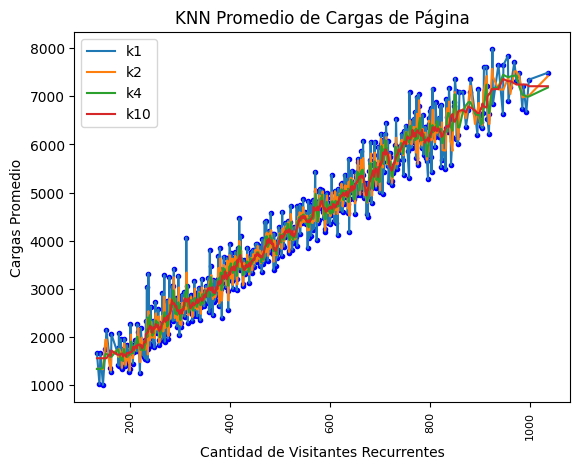

In [41]:
KNN_regression(df, "returning_visits", "mean_load",[1,2,4,10])

Comparando la R ajustada de los modelos, se concluye que el mejor modelo es KNN con k=2.\
Se tiene un 97.29 %